In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
from keras.utils.vis_utils import plot_model
import sklearn
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
import math
import matplotlib.pyplot as plt

%matplotlib inline
warnings.filterwarnings("ignore")
init_notebook_mode(connected=True)

# Set seeds to make the experiment more reproducible.
#from tensorflow import set_random_seed
from numpy.random import seed
#set_random_seed(1)
seed(1)

train = pd.read_csv('../data/train.csv',',')

train.describe()

,Lateness,Assembly,Material,OpenOrders,NewOrders,TotalWork,TotalSetup,SumDuration,SumOperations,ProductionOrders,CycleTime
count,21706.000000,21706.000000,2.170600e+04,21706.000000,21706.000000,21706.000000,21706.00000,21706.000000,21706.000000,21706.000000,21706.000000
mean,-1750.762506,200.791858,1.662879e+09,12.014881,1.922740,4.515505,9.60973,218.946190,21.905234,4.381047,2738.647931
std,183.024606,91.489176,7.597969e+08,3.342536,1.380742,1.578346,2.64050,76.466116,7.574202,1.514840,1014.141497
min,-3117.000000,6.721726,3.780357e+07,3.000000,0.000000,0.000000,0.00000,133.000000,15.000000,3.000000,1332.000000
25%,-1855.503600,124.365403,1.036997e+09,10.000000,1.000000,3.510000,8.26000,151.000000,15.000000,3.000000,1952.000000
50%,-1757.102200,211.274055,1.745468e+09,12.000000,2.000000,4.650000,10.41000,201.000000,20.000000,4.000000,2494.000000
75%,-1643.731700,279.481000,2.312577e+09,14.000000,3.000000,5.620000,11.59000,256.000000,25.000000,5.000000,3352.000000
max,0.000000,393.516050,3.205616e+09,28.000000,9.000000,10.070000,13.71000,575.000000,55.000000,11.000000,8582.000000


In [2]:
train

,Lateness,Assembly,Material,OpenOrders,NewOrders,TotalWork,TotalSetup,SumDuration,SumOperations,ProductionOrders,CycleTime
0,-1163.0000,26.124107,1.257440e+08,13,1,3.90,9.66,153,15,3,1995
1,-1168.0000,27.706510,1.567474e+08,11,2,3.92,10.30,214,20,4,3148
2,-1262.1111,28.959490,1.743148e+08,11,2,3.55,8.24,249,25,5,3364
3,-1280.5834,29.413542,1.859812e+08,10,2,3.69,9.17,155,15,3,1750
4,-1551.2667,38.375523,2.441354e+08,10,0,4.32,9.93,248,25,5,2814
...,...,...,...,...,...,...,...,...,...,...,...
21701,-1764.1119,345.123660,2.865520e+09,15,1,4.52,10.42,198,20,4,2313
21702,-1768.2643,345.343660,2.852534e+09,15,3,2.75,5.35,154,15,3,2042
21703,-1774.1343,345.276700,2.896368e+09,16,4,4.44,9.42,347,35,7,3546
21704,-1773.7039,347.674400,2.907367e+09,16,4,5.57,10.23,252,25,5,2903


In [3]:
split_fraction = 0.70
train_split = int(split_fraction * int(train.shape[0]))
step = 1

#past = 0
#future = 8
learning_rate = 0.0005
batch = 32
epochs = 100
mean = 0
std = 0

def normalize(data, train_split):
    global mean
    global std
    data_mean = data[:train_split].mean(axis=0)
    mean = data_mean
    data_std = data[:train_split].std(axis=0)
    std = data_std
    return (data - data_mean) / data_std

In [4]:
titles = ['Lateness',
          'Assembly',
          'Material',
          'OpenOrders',
          'NewOrders',
          'TotalWork',
          'TotalSetup',
          'SumDuration',
          'SumOperations',
          'ProductionOrders',
          'CycleTime']
#  
# for c in train.columns:
#     titles.append(c);
    
features = train[titles]
features = normalize(features.values, train_split)
features = pd.DataFrame(features)
features.head()

,0,1,2,3,4,5,6,7,8,9,10
0,3.405968,-1.906047,-2.020762,0.267011,-0.678643,-0.404097,-0.042477,-0.843696,-0.900201,-0.900201,-0.718531
1,3.377791,-1.888892,-1.980294,-0.322578,0.042276,-0.391717,0.194175,-0.053710,-0.243348,-0.243348,0.409725
2,2.847446,-1.875308,-1.957363,-0.322578,0.042276,-0.620752,-0.567549,0.399561,0.413506,0.413506,0.621089
3,2.743349,-1.870386,-1.942135,-0.617373,0.042276,-0.534090,-0.223664,-0.817795,-0.900201,-0.900201,-0.958274
4,1.217965,-1.773229,-1.866226,-0.617373,-1.399562,-0.144112,0.057360,0.386610,0.413506,0.413506,0.082892


In [5]:
train_data = features.loc[0 : train_split - 1] #Training Data
val_data = features.loc[train_split:] #Validation Data
train_data

,0,1,2,3,4,5,6,7,8,9,10
0,3.405968,-1.906047,-2.020762,0.267011,-0.678643,-0.404097,-0.042477,-0.843696,-0.900201,-0.900201,-0.718531
1,3.377791,-1.888892,-1.980294,-0.322578,0.042276,-0.391717,0.194175,-0.053710,-0.243348,-0.243348,0.409725
2,2.847446,-1.875308,-1.957363,-0.322578,0.042276,-0.620752,-0.567549,0.399561,0.413506,0.413506,0.621089
3,2.743349,-1.870386,-1.942135,-0.617373,0.042276,-0.534090,-0.223664,-0.817795,-0.900201,-0.900201,-0.958274
4,1.217965,-1.773229,-1.866226,-0.617373,-1.399562,-0.144112,0.057360,0.386610,0.413506,0.413506,0.082892
...,...,...,...,...,...,...,...,...,...,...,...
15189,0.182571,-0.769740,-0.765126,-0.617373,1.484113,-0.707413,-0.807899,0.347758,0.413506,0.413506,0.025159
15190,0.182571,-0.728774,-0.720268,-0.027784,0.042276,0.276817,0.456710,-0.934350,-0.900201,-0.900201,-0.530652
15191,0.156732,-0.714221,-0.728253,-0.027784,0.042276,0.016832,0.079546,-0.869597,-0.900201,-0.900201,-0.804643
15192,0.135317,-0.725662,-0.730165,-0.027784,0.042276,-1.010730,-0.216269,1.668719,1.727213,1.727213,1.513517


In [6]:
#start = past + future
start = 0
end = start + train_split

x_train = train_data[[i for i in range(len(titles) - 1)]].values
y_train = features.iloc[start:end][[len(titles)-1]]

#sequence_length = int(past / step)
sequence_length = 1
x_train[0]

array([ 3.40596794, -1.90604653, -2.02076244,  0.26701077, -0.67864301,
       -0.40409715, -0.0424774 , -0.84369596, -0.90020148, -0.90020148])

In [7]:
dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    x_train,
    y_train,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch
)

In [8]:
label_start = train_split
valRange = int(train.shape[0]) - train_split

# x_val = val_data.iloc[[i for i in range(valRange)]].values
x_val = val_data[[i for i in range(len(titles) - 1)]].values
# x_val = val_data.iloc[[i for i in range(49)]].values
y_val = features.iloc[label_start:][[len(titles)-1]]

dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    x_val,
    y_val,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch
)

for batch in dataset_train.take(1):
    inputs, targets = batch
print(x_val)
print(y_val)
print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)
print(inputs)

[[ 0.18607997 -0.60729696 -0.65313019 ...  1.03413971  1.07035914
   1.07035914]
 [ 0.22475679 -0.62240021 -0.65231699 ...  1.07299148  1.07035914
   1.07035914]
 [ 0.28731549 -0.56523332 -0.61179663 ... -0.26091937 -0.24334794
  -0.24334794]
 ...
 [-0.03796304  1.55388793  1.59573777 ...  1.66871866  1.72721268
   1.72721268]
 [-0.0355376   1.5798814   1.61009491 ...  0.43841253  0.4135056
   0.4135056 ]
 [-0.05124546  1.59860382  1.63314237 ... -0.31272174 -0.24334794
  -0.24334794]]
             10
15194  1.206256
15195  0.884316
15196 -0.029640
15197 -0.779201
15198  1.194513
...         ...
21701 -0.407356
21702 -0.672540
21703  0.799183
21704  0.169983
21705 -0.612849

[6512 rows x 1 columns]
Input shape: (32, 1, 10)
Target shape: (32, 1)
tf.Tensor(
[[[ 3.40596794 -1.90604653 -2.02076244  0.26701077 -0.67864301
   -0.40409715 -0.0424774  -0.84369596 -0.90020148 -0.90020148]]

 [[ 3.37779139 -1.88889169 -1.9802937  -0.32257819  0.04227581
   -0.39171689  0.19417457 -0.05370992 -0.

In [27]:
# Long Short Term Memory - Model als Methodik mit Adam --> stochastic gradient descent algorithm

inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
#dropout1 = keras.layers.Dropout(0.4)(inputs)
hidden1 = keras.layers.LSTM(512, return_sequences=True)(inputs)
hidden2 = keras.layers.LSTM(512, return_sequences=True)(hidden1)
hidden3 = keras.layers.LSTM(512, return_sequences=True)(hidden2)
lasthidden = keras.layers.LSTM(512)(hidden3)
#dropout2 = keras.layers.Dropout(0.4)(hidden1)
outputs = keras.layers.Dense(1)(lasthidden)
learning_rate = 0.001
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.99), loss=keras.losses.MeanSquaredError()) #metrics=keras.metrics.MeanAbsoluteError())
model.summary()
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
model.save("kerasModel")

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1, 10)]           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 1, 512)            1071104   
_________________________________________________________________
lstm_5 (LSTM)                (None, 1, 512)            2099200   
_________________________________________________________________
lstm_6 (LSTM)                (None, 1, 512)            2099200   
_________________________________________________________________
lstm_7 (LSTM)                (None, 512)               2099200   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 513       
Total params: 7,369,217
Trainable params: 7,369,217
Non-trainable params: 0
_________________________________________________

In [28]:
path_checkpoint = "kerasModel/simpleModelCheckpoint.h5"

def scheduler(epoch, lr):
    return 0.001
    if lr > 0.004:
        return lr - 0.0002
    else:
        if lr > 0.0004:
            return lr - 0.000001
        else:            
            return 0.0001

es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=10)

lr_scheduler = keras.callbacks.LearningRateScheduler(scheduler, verbose=1)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True
)

epochs = 4000

history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[es_callback,modelckpt_callback, lr_scheduler]
)

Epoch 1/4000

Epoch 00001: LearningRateScheduler reducing learning rate to 0.001.
475/475 [==============================] - 24s 41ms/step - loss: 0.9991 - val_loss: 0.9475

Epoch 00001: val_loss improved from inf to 0.94746, saving model to kerasModel\simpleModelCheckpoint.h5
Epoch 2/4000

Epoch 00002: LearningRateScheduler reducing learning rate to 0.001.
475/475 [==============================] - 19s 41ms/step - loss: 0.9659 - val_loss: 0.7744

Epoch 00002: val_loss improved from 0.94746 to 0.77438, saving model to kerasModel\simpleModelCheckpoint.h5
Epoch 3/4000

Epoch 00003: LearningRateScheduler reducing learning rate to 0.001.
475/475 [==============================] - 19s 40ms/step - loss: 0.2742 - val_loss: 0.1267

Epoch 00003: val_loss improved from 0.77438 to 0.12668, saving model to kerasModel\simpleModelCheckpoint.h5
Epoch 4/4000

Epoch 00004: LearningRateScheduler reducing learning rate to 0.001.
475/475 [==============================] - 19s 40ms/step - loss: 0.1213 - va

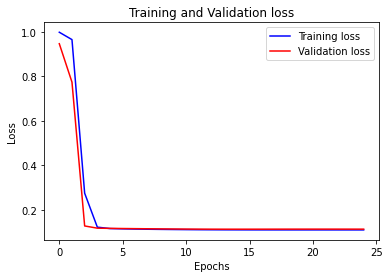

In [29]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    
visualize_loss(history, "Training and Validation loss")

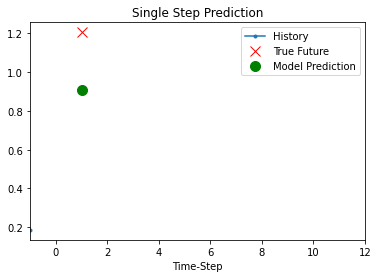

In [30]:
def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()
    return

for x, y in dataset_val.take(1):
    show_plot(
        [x[0][:, 0].numpy(), y[0].numpy(), model.predict(x)[0]],
        1,
        "Single Step Prediction",
    )

In [31]:
def denormalize(value):
    data_mean = mean[len(titles)-1]
    data_std = std[len(titles)-1]
    return value*data_std+data_mean

for x, y in dataset_val.take(10):
    predictionData = model.predict(x)
    denormalized_predictionData = denormalize(predictionData)[0]
    actualValue = y[0].numpy()
    print("predicted denormalized:", denormalized_predictionData)
    print("   actual denormalized:", denormalize(actualValue))
    print("             predicted:", predictionData[0])
    print("                actual:", actualValue)

# for x, y in datasetPredTest.take(1):
#     show_plot(
#         [x[0][:, 0].numpy(), y[0].numpy(), model.predict(x)[0]],
#         1,
#         "Single Step Prediction",
#     )

predicted denormalized: [3660.935]
   actual denormalized: [3961.93393179]
             predicted: [0.9094473]
                actual: [1.20625592]
predicted denormalized: [1970.948]
   actual denormalized: [1799.59298878]
             predicted: [-0.75701237]
                actual: [-0.92598181]
predicted denormalized: [1950.4666]
   actual denormalized: [1636.84681409]
             predicted: [-0.7772086]
                actual: [-1.0864623]
predicted denormalized: [3033.3772]
   actual denormalized: [3026.14342731]
             predicted: [0.29062605]
                actual: [0.2834931]
predicted denormalized: [1909.251]
   actual denormalized: [1911.72907256]
             predicted: [-0.81785035]
                actual: [-0.81540683]
predicted denormalized: [1893.2123]
   actual denormalized: [1844.24895135]
             predicted: [-0.83366585]
                actual: [-0.88194753]
predicted denormalized: [2577.6313]
   actual denormalized: [2704.62049683]
             predicted:

In [14]:
def normalize(data):
    return (data - mean) / std

predTest = pd.read_csv('../data/test_val.csv',',')
mean = train[titles].values.mean(axis=0)
std = train[titles].values.std(axis=0)
featuresPredTest = predTest[titles]
predTestRange = int(featuresPredTest.shape[0])
featuresPredTest = normalize(featuresPredTest.values)
featuresPredTest = pd.DataFrame(featuresPredTest)
x_predTest = featuresPredTest[[i for i in range(10)]].values
y_predTest = featuresPredTest.iloc[0:][[10]]

datasetPredTest = keras.preprocessing.timeseries_dataset_from_array(
    x_predTest,
    y_predTest,
    sequence_length=1,
    sampling_rate=1,
    batch_size=1
)

for x, y in datasetPredTest.take(10):
    predictionData = model.predict(x)
    denormalized_predictionData = denormalize(predictionData)
    print("predicted denormalized:", denormalized_predictionData)
    print("   actual denormalized:", denormalize(y[0].numpy()))
    print("             predicted:", predictionData)
    print("                actual:", y[0].numpy())

predicted denormalized: [[2421.7744]]
   actual denormalized: [2357.]
             predicted: [[-0.3124622]]
                actual: [-0.37633479]
predicted denormalized: [[2386.2842]]
   actual denormalized: [2566.]
             predicted: [[-0.34745836]]
                actual: [-0.1702444]
predicted denormalized: [[3595.429]]
   actual denormalized: [3230.]
             predicted: [[0.8448533]]
                actual: [0.48451167]
predicted denormalized: [[3215.875]]
   actual denormalized: [2681.]
             predicted: [[0.47058332]]
                actual: [-0.05684538]
predicted denormalized: [[1754.5969]]
   actual denormalized: [1748.]
             predicted: [[-0.97035146]]
                actual: [-0.97685654]
predicted denormalized: [[1783.121]]
   actual denormalized: [2064.]
             predicted: [[-0.9422245]]
                actual: [-0.66525576]
predicted denormalized: [[2254.8433]]
   actual denormalized: [2810.]
             predicted: [[-0.47706926]]
            

In [15]:
# for x,y in datasetPredTest.take(2):
#     print(x[0][0].numpy(
normalize(featuresPredTest.values)

array([[ 9.57056263, -2.21558466, -2.18863405, -3.32742707, -0.8274864 ,
        -2.29716242, -3.42282226, -2.8664453 , -2.92536327, -3.0582111 ,
        -2.7008927 ],
       [ 9.57313604, -2.214993  , -2.18863405, -3.32742707, -1.87660656,
        -2.44970793, -3.62936511, -2.8664453 , -2.92536327, -3.0582111 ,
        -2.70068948],
       [ 9.57506631, -2.2146069 , -2.18863405, -3.32742707, -1.35204648,
        -2.46977971, -3.41278198, -2.85019709, -2.75104366, -2.18661305,
        -2.70004383],
       [ 9.57832796, -2.21398669, -2.18863405, -3.23791786, -0.8274864 ,
        -2.56612425, -3.27938972, -2.85567017, -2.83820346, -2.62241207,
        -2.70057766],
       [ 9.58014845, -2.21396186, -2.18863405, -3.14840866, -0.8274864 ,
        -2.57013861, -3.44003416, -2.87619423, -3.01252307, -3.49401012,
        -2.70148486],
       [ 9.57979667, -2.2133324 , -2.18863405, -3.14840866, -1.35204648,
        -2.34533468, -3.33245976, -2.87533906, -3.01252307, -3.49401012,
        -2.701

In [16]:
cc=denormalize(0.4095)
cc2=denormalize(0)
print(cc, cc2)
print(cc2 - cc)

3153.9293079465024 2738.647931447526
-415.28137649897644


In [17]:
x_train

array([[ 3.40596794, -1.90604653, -2.02076244, ..., -0.84369596,
        -0.90020148, -0.90020148],
       [ 3.37779139, -1.88889169, -1.9802937 , ..., -0.05370992,
        -0.24334794, -0.24334794],
       [ 2.84744621, -1.87530813, -1.95736292, ...,  0.39956076,
         0.4135056 ,  0.4135056 ],
       ...,
       [ 0.1567324 , -0.71422091, -0.72825345, ..., -0.86959714,
        -0.90020148, -0.90020148],
       [ 0.13531654, -0.72566164, -0.73016519, ...,  1.66871866,
         1.72721268,  1.72721268],
       [ 0.20596585, -0.64864747, -0.67820922, ..., -1.02500423,
        -0.90020148, -0.90020148]])

In [18]:
x_train.shape

(15194, 10)

In [19]:
y_train

,10
0,-0.718531
1,0.409725
2,0.621089
3,-0.958274
4,0.082892
...,...
15189,0.025159
15190,-0.530652
15191,-0.804643
15192,1.513517


In [20]:
y_train.shape

(15194, 1)

In [21]:
mean

array([-1.75076251e+03,  2.00791858e+02,  1.66287906e+09,  1.20148807e+01,
        1.92274026e+00,  4.51550539e+00,  9.60973049e+00,  2.18946190e+02,
        2.19052336e+01,  4.38104672e+00,  2.73864793e+03])

In [22]:
std

array([1.83020390e+02, 9.14870689e+01, 7.59779397e+08, 3.34245944e+00,
       1.38070972e+00, 1.57830914e+00, 2.64043914e+00, 7.64643546e+01,
       7.57402750e+00, 1.51480550e+00, 1.01411814e+03])

In [23]:
train[titles].values.mean(axis=0)

array([-1.75076251e+03,  2.00791858e+02,  1.66287906e+09,  1.20148807e+01,
        1.92274026e+00,  4.51550539e+00,  9.60973049e+00,  2.18946190e+02,
        2.19052336e+01,  4.38104672e+00,  2.73864793e+03])

In [24]:
test = [[[3.96250010e+00, 5.92916600e+07, 7.00000000e+00, 7.00000000e+00, 4.53000021e+00, 1.08999996e+01, 1.99000000e+02, 2.00000000e+01, 4.00000000e+00, 0.00000000e+00]]]

In [25]:
test

[[[3.9625001,
   59291660.0,
   7.0,
   7.0,
   4.53000021,
   10.8999996,
   199.0,
   20.0,
   4.0,
   0.0]]]

In [26]:
(test-train[titles].values.mean(axis=0))/train[titles].values.std(axis=0)

ValueError: operands could not be broadcast together with shapes (1,1,10) (11,) 

In [17]:
train[titles].values.mean(axis=0)

array([-1.75083294e+03,  2.00750551e+02,  1.66239649e+09,  1.19796115e+01,
        1.91216897e+00,  4.49067901e+00,  9.55689590e+00,  2.18859067e+02,
        2.18968203e+01,  4.37936406e+00,  2.73739641e+03])

In [18]:
train[titles].values.std(axis=0)

array([1.83037727e+02, 9.15228348e+01, 7.60116407e+08, 3.36948488e+00,
       1.38422981e+00, 1.60899072e+00, 2.72736533e+00, 7.63923341e+01,
       7.56692744e+00, 1.51338549e+00, 1.01327208e+03])

In [ ]:
targets

In [ ]:
train_data.shape

In [14]:
y_val.values

array([[ 1.18080767],
       [ 0.19404747],
       [ 0.36203571],
       ...,
       [-0.93475157],
       [-0.51751248],
       [-0.90675353]])

In [13]:
x_val.shape

(52895, 7)